1. Create dataset with weak labels


In [1]:
%load_ext autoreload
%autoreload 2

In [9]:

from monai.transforms import Resize, EnsureChannelFirst, Compose, AsDiscrete, ThresholdIntensity, NormalizeIntensity
from monai.networks.nets import Classifier
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
from torch.nn import BCELoss
from torch.nn.functional import sigmoid, relu
from torch import nan_to_num
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [10]:
path_to_aires_ganglionnaires = '/home/francescocremonesiext/new-areas/aires-ganglionnaires/output/cal_cancer_patients_bb/SEG'
patient_list = os.listdir(path_to_aires_ganglionnaires)

In [11]:
to_remove = []
for i, pat in enumerate(patient_list):
    if len(os.listdir(os.path.join(path_to_aires_ganglionnaires, pat))) < 15:
        to_remove.append(pat)

In [12]:
for rm in to_remove:
    patient_list.pop(patient_list.index(rm))

In [13]:
len(patient_list)

324

## Dataset definition

In [14]:
from weakly_supervised_library import CAL_WSISDataset

In [15]:
common_shape = (128,128,64)
#common_shape = (32,32,64)
window=350
level=40
whole_dataset = CAL_WSISDataset(
    '/mnt/lvssd/common/AI4PET/data_v1.0.0/data/02_intermediate/CAL/CT',
    path_to_aires_ganglionnaires,
    patient_list,
    'level_iii_left',
    transforms = {
        'data': Compose((
                EnsureChannelFirst(channel_dim='no_channel'),
                Resize(common_shape),
                NormalizeIntensity(subtrahend=level-0.5*window, divisor=window),
                ThresholdIntensity(1, above=False, cval=1),
                ThresholdIntensity(0, above=True, cval=0),
                )),
        'label': Compose((
                EnsureChannelFirst(channel_dim='no_channel'),
                Resize(common_shape),
                AsDiscrete(threshold=0.5),
                )),
    },
    min_crop_shape=common_shape,
    force_recompute_bbox=False,
    crop_images=True,
    only_crop_z=False
)


In [16]:
train_indices, test_indices = train_test_split(list(range(len(whole_dataset))), test_size=0.2, random_state=4242)

In [17]:
train_indices = train_indices[:1]

In [18]:
train_dataset = Subset(whole_dataset, train_indices)
test_dataset = Subset(whole_dataset, test_indices)

In [19]:
len(train_dataset), len(test_dataset)

(1, 65)

In [20]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,  #True
    num_workers=0,
)

In [ ]:
def mask_image()

## Loss definition

## Model

In [50]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(32,64,128), 
    strides=(2,2),
    
)

## Optimizer

In [41]:
optimizer = Adam(model.parameters(), lr=5e-5)

## Train loop

In [42]:
n_epochs = 40
n_val_iter = 0
n_updates_per_epoch = 1

### Test fully supervised

In [220]:
from torch.nn import BCELoss
fully_supervised_ce = BCELoss()

In [205]:
for epoch in range(n_epochs):
    model.train()
    data_iter = iter(train_dataloader)
    n_train_iter_done = 0
    train_loss = 0.
    for _ in tqdm(range(n_updates_per_epoch)):
        while(True):
            try:
                img, lab = next(data_iter)
                break
            except EOFError:
                continue
            except ValueError:
                continue
            except StopIteration:
                break
        
        optimizer.zero_grad()
        pred = model(img)
        pred = sigmoid(pred)
        loss = fully_supervised_ce(pred,lab)
        print(f'CE Loss: {loss.detach().numpy()}')
        loss.backward()
        optimizer.step()
        n_train_iter_done += 1
        train_loss += loss.detach().numpy()
    print(f'Epoch {epoch:02d} Train loss {train_loss/(1e-11+n_train_iter_done):0.8f}')
    
    model.eval()
    with torch.no_grad():
        print(f'Epoch {epoch:02d} Validation loss {dsc(pred,lab):0.8f}')
        
    #sz_loss_fn.step_barrier()
    #tight_loss_fn.step_barrier()
    


  0%|          | 0/1 [00:04<?, ?it/s]


NameError: name 'fully_supervised_ce' is not defined

### Test overfit

In [43]:
from collections import defaultdict

In [44]:
loss_lambda = 1

In [45]:
losses = defaultdict(lambda: [])

for epoch in range(n_epochs):
    model.train()
    data_iter = iter(train_dataloader)
    n_train_iter_done = 0
    train_loss = 0.
    for _ in tqdm(range(n_updates_per_epoch)):
        while(True):
            try:
                img, lab = next(data_iter)
                break
            except EOFError:
                continue
            except ValueError:
                continue
            except StopIteration:
                break
        with torch.no_grad():
            bbox_coords = CAL_WSISDataset.get_bbox_and_collate(lab)
        optimizer.zero_grad()
        pred = model(img)
        pred = sigmoid(pred)
        #ce_loss = ce_loss_fn(pred, lab)
        #ce_loss = ce_loss.mean()
        #print(f'CE Loss: {ce_loss.detach().numpy()}')
        #losses['ce'].append(ce_loss.detach().numpy())
        
        sz_loss = loss_lambda*sz_loss_fn(pred, lab).mean()
        #print(f'SZ loss: {sz_loss.detach().numpy()}')
        losses['sz'].append(sz_loss.detach().numpy())

        tp_loss = loss_lambda*tight_loss_fn(pred, lab, bbox_coords).mean()
        #print(f'TP loss: {tp_loss.detach().numpy()}')
        losses['tp'].append(tp_loss.detach().numpy())

        ec_loss = emptyness_constraint_fn(pred,lab).mean()
        #print(f'EC loss: {ec_loss.detach().numpy()}')
        losses['ec'].append(ec_loss.detach().numpy())

        loss = sz_loss + tp_loss + ec_loss  #ce_loss + sz_loss + tp_loss + ec_loss
        loss.backward()
        optimizer.step()
        n_train_iter_done += 1
        train_loss += loss.detach().numpy()
    print(f'Epoch {epoch:02d} Train loss {train_loss/(1e-11+n_train_iter_done):0.8f}')
    
    model.eval()
    with torch.no_grad():
        print(f'Epoch {epoch:02d} Validation loss {dsc(pred,lab):0.8f}')
        losses['val'].append(dsc(pred,lab))
        
    #sz_loss_fn.step_barrier()
    #tight_loss_fn.step_barrier()
    


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [02:00<?, ?it/s]


TypeError: Log_barrier_emptyness_constraint.__call__() missing 1 required positional argument: 'bbox_coords'

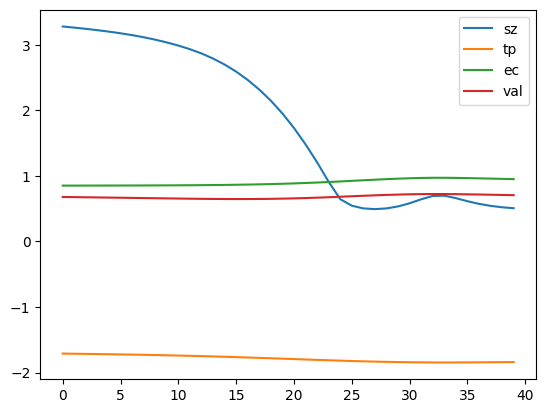

In [ ]:
for lname, l in losses.items():
    #if lname == 'val':
    #    continue
    plt.plot(l, label=lname)
plt.legend()

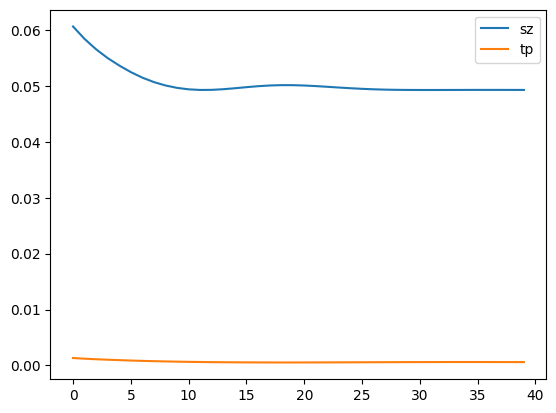

In [ ]:
plt.plot(losses['sz'], label='sz')
plt.plot(losses['tp'], label='tp')
plt.legend()

### Test full training loop

In [127]:
for epoch in range(n_epochs):
    val_iter = iter(test_dataloader)
    val_loss = 0.
    model.eval()
    n_val_iter_done = 0
    with torch.no_grad():
        for _ in tqdm(range(n_val_iter)):
            while(True):
                try:
                    img, lab = next(val_iter)
                    break
                except EOFError:
                    continue
            n_val_iter_done += 1
            pred = model(img)
            val_loss += dsc(pred,lab)
    print(f'Epoch {epoch:02d} Validation loss {val_loss/(1e-11+n_val_iter_done):0.8f}')

    model.train()
    data_iter = iter(train_dataloader)
    n_train_iter_done = 0
    train_loss = 0.
    for _ in tqdm(range(n_updates_per_epoch)):
        while(True):
            try:
                img, lab = next(data_iter)
                break
            except EOFError:
                continue
            except ValueError:
                continue
            except StopIteration:
                break
        with torch.no_grad():
            bbox_coords = CAL_WSISDataset.get_bbox_and_collate(lab)
        optimizer.zero_grad()
        pred = model(img)
        pred = sigmoid(pred)
        ce_loss = ce_loss_fn(pred, lab)
        ce_loss = ce_loss.mean()
        print(f'CE Loss: {ce_loss.detach().numpy()}')
        sz_loss = loss_lambda*sz_loss_fn(pred, lab).mean()
        print(f'SZ loss: {sz_loss.detach().numpy()}')
        tp_loss = loss_lambda*tight_loss_fn(pred, lab, bbox_coords).mean()
        print(f'TP loss: {tp_loss.detach().numpy()}')
        ec_loss = emptyness_constraint_fn(pred,lab).mean()
        print(f'EC loss: {ec_loss.detach().numpy()}')
        loss = ce_loss + sz_loss + tp_loss + ec_loss
        loss.backward()
        optimizer.step()
        n_train_iter_done += 1
        train_loss += loss.detach().numpy()
    print(f'Epoch {epoch:02d} Train loss {train_loss/(1e-11+n_train_iter_done):0.8f}')
        
    sz_loss_fn.step_barrier()
    tight_loss_fn.step_barrier()
    


0it [00:00, ?it/s]


Epoch 00 Validation loss 0.00000000


  0%|          | 0/1 [00:00<?, ?it/s]

CE Loss: 0.8647768497467041
SZ loss: 0.054856041604280474
TP loss: 0.0002901477855630219
EC loss: 3.4878313541412354


100%|██████████| 1/1 [00:17<00:00, 17.79s/it]


Epoch 00 Train loss 4.40775439


0it [00:00, ?it/s]


Epoch 01 Validation loss 0.00000000


  0%|          | 0/1 [00:00<?, ?it/s]

CE Loss: 0.8226252794265747
SZ loss: 0.0586116172850132
TP loss: 0.0003135971201118082
EC loss: 3.412274122238159


100%|██████████| 1/1 [00:21<00:00, 21.25s/it]


Epoch 01 Train loss 4.29382462


0it [00:00, ?it/s]


Epoch 02 Validation loss 0.00000000


  0%|          | 0/1 [00:00<?, ?it/s]

CE Loss: 0.7851669192314148
SZ loss: 0.06224688658714295
TP loss: 0.0003419492277316749
EC loss: 3.3246567249298096


100%|██████████| 1/1 [00:21<00:00, 21.87s/it]


Epoch 02 Train loss 4.17241248


0it [00:00, ?it/s]


Epoch 03 Validation loss 0.00000000


  0%|          | 0/1 [00:00<?, ?it/s]

CE Loss: 0.7476335167884827
SZ loss: 0.06636380382776261
TP loss: 0.00037301777047105134
EC loss: 3.2492618560791016


100%|██████████| 1/1 [00:14<00:00, 14.54s/it]


Epoch 03 Train loss 4.06363219


0it [00:00, ?it/s]


Epoch 04 Validation loss 0.00000000


  0%|          | 0/1 [00:00<?, ?it/s]

CE Loss: 0.7178901433944702
SZ loss: 0.0709508394420147
TP loss: 0.0004074581083841622
EC loss: 3.1826171875


100%|██████████| 1/1 [00:13<00:00, 13.51s/it]


Epoch 04 Train loss 3.97186563


0it [00:00, ?it/s]


Epoch 05 Validation loss 0.00000000


  0%|          | 0/1 [00:00<?, ?it/s]

CE Loss: 0.6908506751060486
SZ loss: 0.07611688922643661
TP loss: 0.0004456175083760172
EC loss: 3.1255884170532227


100%|██████████| 1/1 [00:15<00:00, 15.52s/it]


Epoch 05 Train loss 3.89300160


0it [00:00, ?it/s]


Epoch 06 Validation loss 0.00000000


  0%|          | 0/1 [00:00<?, ?it/s]

CE Loss: 0.6678215265274048
SZ loss: 0.08198553016483784
TP loss: 0.000488018587930128
EC loss: 3.0788066387176514


100%|██████████| 1/1 [00:15<00:00, 15.74s/it]


Epoch 06 Train loss 3.82910171


0it [00:00, ?it/s]


Epoch 07 Validation loss 0.00000000


  0%|          | 0/1 [00:00<?, ?it/s]

CE Loss: 0.6486358046531677
SZ loss: 0.08852543978095055
TP loss: 0.0005346629768610001
EC loss: 3.038325548171997


100%|██████████| 1/1 [00:13<00:00, 13.81s/it]


Epoch 07 Train loss 3.77602146


0it [00:00, ?it/s]


Epoch 08 Validation loss 0.00000000


  0%|          | 0/1 [00:00<?, ?it/s]

CE Loss: 0.6322018504142761
SZ loss: 0.09567449194192887
TP loss: 0.0005857544601894915
EC loss: 3.0005221366882324


100%|██████████| 1/1 [00:22<00:00, 22.59s/it]


Epoch 08 Train loss 3.72898423


0it [00:00, ?it/s]


Epoch 09 Validation loss 0.00000000


  0%|          | 0/1 [00:00<?, ?it/s]

CE Loss: 0.6171553730964661
SZ loss: 0.10339358685612679
TP loss: 0.0006420811987482011
EC loss: 2.9632411003112793


100%|██████████| 1/1 [00:21<00:00, 21.88s/it]

Epoch 09 Train loss 3.68443214


## Save model

In [116]:
with open(f'weakly_supervised_model_overfit_fullysupervised.pth', 'wb') as f:
    torch.save(model, f)

In [28]:
with open(f'weakly_supervised_model_overfit_fullysupervised.pth', 'rb') as f:
#with open(f'weakly_supervised_model_16.pth', 'rb') as f:
    model = torch.load(f, weights_only=False)

## Inference on trained model

In [18]:
# for validation
dsc = DiceLoss()
bce = BCELoss()

In [19]:
#val_iter = iter(train_dataloader)
val_iter = iter(test_dataloader)

In [20]:
model.eval()
with torch.no_grad():
    img, lab = next(val_iter)
    pred = model(img)
    pred = sigmoid(pred)
    val_loss = dsc(pred,lab)
    bce_loss = bce(pred,lab)
    print(f'Validation loss {val_loss:0.8f} bce {bce_loss:0.8f}')

Validation loss 0.99987400 bce 0.66125512


In [49]:
pred = pred[0,...]
img = img[0,...]
lab = lab[0,...]

In [50]:
lab.min(), lab.max()

(metatensor(0.), metatensor(1.))

In [51]:
pred.min(), pred.max()

(metatensor(4.4485e-11), metatensor(0.0081))

0.008079998


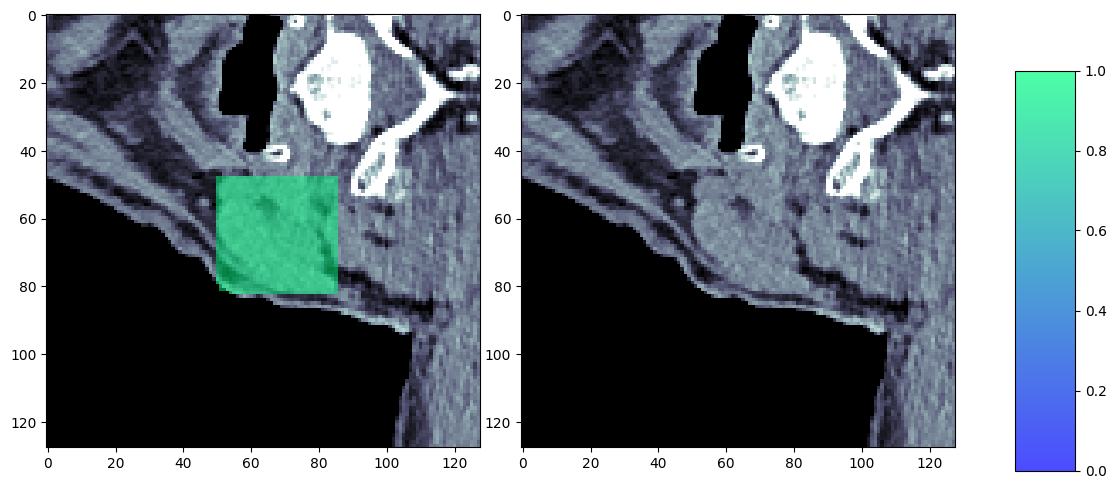

In [52]:
fig, ax = plt.subplots(1,2,figsize=(12,8))

npimg = img.detach().numpy().squeeze()
nppred = pred.detach().numpy().squeeze()
nplab = lab.detach().numpy().squeeze()

#slice_ = np.where(nplab > 0)[2].max() + np.where(nplab > 0)[2].min()
#slice_ = int(0.5*slice_)
#slice_ = np.argmax(nppred.sum(axis=0).sum(axis=0))
slice_ = np.argmax(nplab.sum(axis=0).sum(axis=0))
#slice_ = np.where(nplab > 0)[2].min() + 5
#slice_ = np.where(nplab > 0)[2].max() - 5

print( nppred[:,:,slice_].max())

ax[0].imshow(npimg[:,:,slice_], cmap='bone')
ax[0].imshow(np.ma.masked_where(nplab[:,:,slice_] < 0.5, nplab[:,:,slice_]), cmap='winter', alpha=0.5, vmin=0., vmax=1., interpolation='none')

ax[1].imshow(npimg[:,:,slice_], cmap='bone')
im = ax[1].imshow(np.ma.masked_where(nppred[:,:,slice_] < 0.5, nppred[:,:,slice_]), cmap='winter', alpha=0.7, vmin=0., vmax=1., interpolation='none')

fig.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.05, 0.5])
fig.colorbar(im, cax=cbar_ax)

In [31]:
pred.shape, lab.shape

(torch.Size([1, 128, 128, 64]), torch.Size([1, 128, 128, 64]))

In [32]:

with torch.no_grad():
    l = sz_loss_fn(pred.unsqueeze(dim=0), lab.unsqueeze(dim=0))
l

metatensor([[4.5336]], dtype=torch.float64)

In [100]:
pred_size = nppred_p.sum()
target_size = nplab.sum()
target_size*0.5, pred_size, target_size/0.5

(807.5, 1160.3273, 3230.0)

In [97]:
t_ = 5.
z = 0.5*target_size - pred_size
mask = (z <= -1./(t_*t_)).astype(np.float64)
l1 = (-1./t_)*np.nan_to_num(np.log(-z))*mask
z, mask, l1

(-352.8272705078125, 1.0, -1.173195723700619)

In [98]:
t_ = 5.
z = 0.5*target_size - pred_size
mask = (z <= -1./(t_*t_)).astype(np.float64)
l1 = (-1./t_)*np.nan_to_num(np.log(-z))*mask
l2 = (t_*z - 1/t_*np.log(1./(t_*t_)) + 1./t_)*(1-mask)
z, mask, l1, l2

(-352.8272705078125, 1.0, -1.173195723700619, -0.0)

In [99]:
t_ = 5.
z = pred_size - target_size/0.5
mask = (z <= -1./(t_*t_)).astype(np.float64)
l1 = (-1./t_)*np.nan_to_num(np.log(-z))*mask
l2 = (t_*z - 1/t_*np.log(1./(t_*t_)) + 1./t_)*(1-mask)
z, mask, l1, l2


(-2069.6727294921875, 1.0, -1.5270291544130858, -0.0)

In [ ]:
class Log_barrier_extension:
    def __init__(self, t, mu):
        self.t= t
        self.mu = mu

    def __call__(self, z):
        mask = (z <= -1./(self.t*self.t)).astype(torch.double)
        return (-1./self.t)*nan_to_num(torch.log(-z))*mask + (self.t*z - 1/self.t*np.log(1./(self.t*self.t)) + 1./self.t)*(1-mask)
    
    def step(self):
        self.t *= self.mu



class Log_barrier_size_constraint_criterion:
    def __init__(self, epsilon=0.5, t = 1., mu=1.):
        self.epsilon = epsilon
        self.barrier = Log_barrier_extension(t, mu)

    def __call__(self, pred, target):
        pred_size = pred.sum(axis=(2,3,4))
        target_size = target.sum(axis=(2,3,4))
        return self.barrier(self.epsilon*target_size - pred_size) + self.barrier(pred_size - target_size/self.epsilon)
    
    def step_barrier(self):
        self.barrier.step()

In [103]:
npimg.max()

350.0

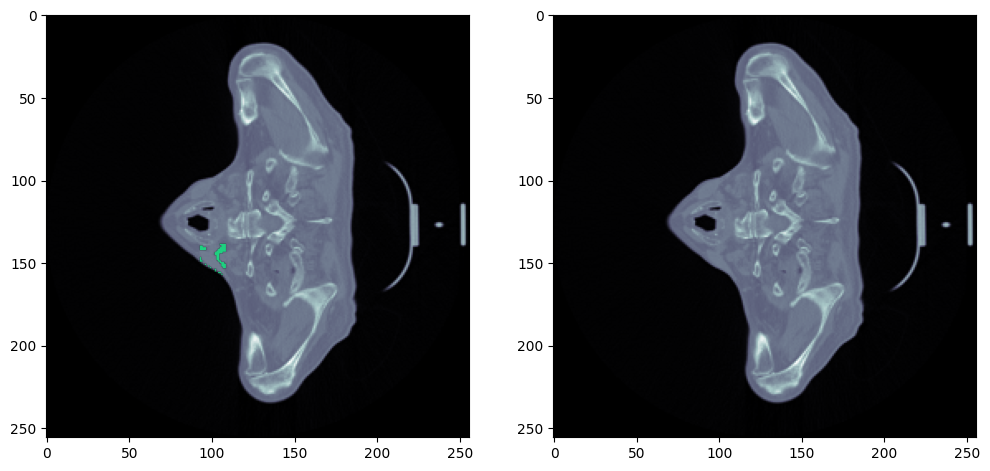

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,8))

npimg = img.detach().numpy().squeeze()
nppred_p = pred_p.detach().numpy().squeeze()
nplab = lab.detach().numpy().squeeze()

slice_ = np.where(nplab > 0)[2].max() + np.where(nplab > 0)[2].min()
slice_ = int(0.5*slice_)


ax[0].imshow(npimg[:,:,slice_], cmap='bone')
ax[0].imshow(np.ma.masked_where(nplab[:,:,slice_] < 0.5, nplab[:,:,slice_]), cmap='winter', alpha=0.7, vmin=0., vmax=1.)

ax[1].imshow(npimg[:,:,slice_], cmap='bone')
ax[1].imshow(np.ma.masked_where(nppred_p[:,:,slice_] < 0.51, nppred_p[:,:,slice_]), cmap='winter', alpha=0.7, vmin=0., vmax=1.)

## Plot one image

In [234]:
whole_dataset.patients[test_indices[0]]

'0007010_20200609'

In [235]:
val_iter = iter(test_dataloader)
with torch.no_grad():
    img, lab = next(val_iter)

In [236]:
bbox_coords = CAL_WSISDataset.get_bbox(lab[0,0,...])
bbox_coords

[[42, 35, 0], [87, 92, 63]]

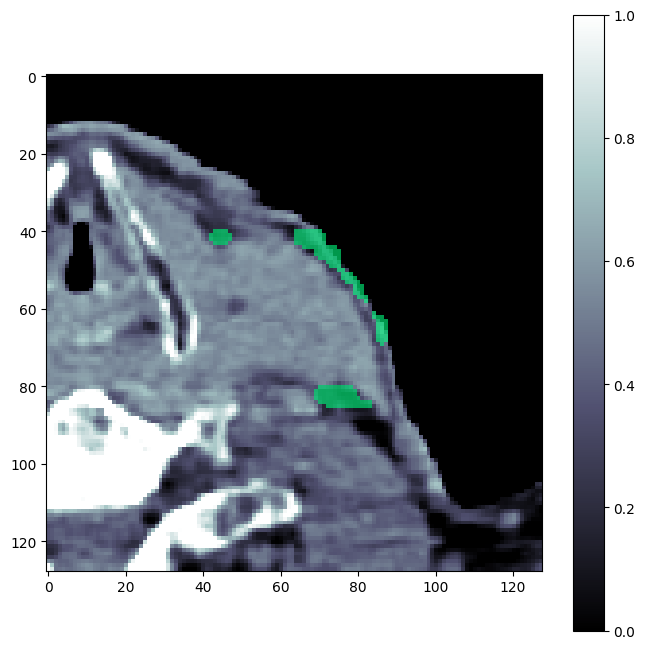

In [237]:
fig, ax = plt.subplots(figsize=(8,8))

npimg = img.detach().numpy().squeeze()
nplab = lab.detach().numpy().squeeze()
#bbox_coords = bbox_coords.detach().numpy().squeeze()

#slice_ = np.where(nplab > 0)[2].max() + np.where(nplab > 0)[2].min()
#slice_ = int(0.5*slice_)
#slice_ = 0
#slice_ = -1
slice_ = np.argmax(nplab.sum(axis=0).sum(axis=0))

ctplot = ax.imshow(npimg[:,:,slice_].T, cmap='bone')
ax.imshow(np.ma.masked_where(nplab[:,:,slice_].T < 0.5, 
                             nplab[:,:,slice_].T), 
                             cmap='winter', alpha=0.6, vmin=0., vmax=1.)

fig.colorbar(ctplot)

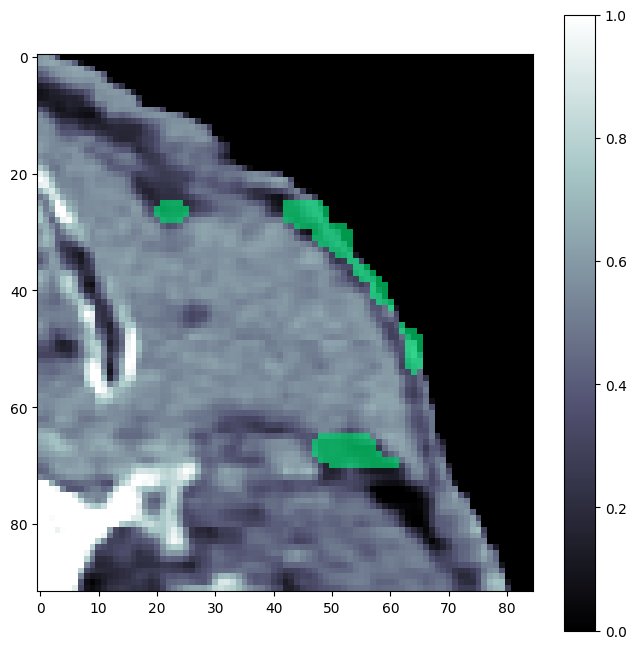

In [238]:
fig, ax = plt.subplots(figsize=(8,8))

npimg = img.detach().numpy().squeeze()
nplab = lab.detach().numpy().squeeze()
#bbox_coords = bbox_coords.detach().numpy().squeeze()

#slice_ = np.where(nplab > 0)[2].max() + np.where(nplab > 0)[2].min()
#slice_ = int(0.5*slice_)
#slice_ = 0
#slice_ = -1
slice_ = np.argmax(nplab.sum(axis=0).sum(axis=0))

ctplot = ax.imshow(npimg[bbox_coords[0][0]-20:bbox_coords[1][0]+20,bbox_coords[0][1]-20:bbox_coords[1][0]+20,slice_].T, cmap='bone')
ax.imshow(np.ma.masked_where(nplab[bbox_coords[0][0]-20:bbox_coords[1][0]+20,bbox_coords[0][1]-20:bbox_coords[1][0]+20,slice_].T < 0.5, 
                             nplab[bbox_coords[0][0]-20:bbox_coords[1][0]+20,bbox_coords[0][1]-20:bbox_coords[1][0]+20,slice_].T), 
                             cmap='winter', alpha=0.6, vmin=0., vmax=1.)

fig.colorbar(ctplot)

In [101]:
whole_dataset.patients[test_indices[0]]

'0007010_20200609'

In [102]:
slice_

0

## Test loss functions

In [ ]:
pred = torch.rand(size=(2,1,2,1,1)) - 0.5
pred.requires_grad = True
#target = torch.zeros_like(pred)
#target[0,0,0,0,0] = 1.
#target[1,0,0,:,0] = 1.
target = (sigmoid(pred)>0.5).float()
print(pred)
print('----')
print(target)

tensor([[[[[0.1968]],

          [[0.0411]]]],



        [[[[0.0694]],

          [[0.0576]]]]], requires_grad=True)
----
tensor([[[[[1.]],

          [[1.]]]],



        [[[[1.]],

          [[1.]]]]])


In [ ]:
pred.grad

In [ ]:
target.sum(axis=(1,2,3,4)).shape

torch.Size([2])

In [ ]:
ce_loss = WeakCELoss()(sigmoid(pred), target)

In [ ]:
ce_loss

tensor([nan, nan], grad_fn=<SumBackward1>)

In [ ]:
ce_loss = ce_loss.mean()
ce_loss

tensor(nan, grad_fn=<MeanBackward0>)

In [ ]:
ce_loss.backward()

In [ ]:
pred.grad

tensor([[[[[nan]],

          [[nan]]]],



        [[[[nan]],

          [[nan]]]]])

In [ ]:
pred.grad = None
ce_loss = WeakCELoss()(sigmoid(pred), target)
ce_loss = ce_loss.mean()
ce_loss

tensor(nan, grad_fn=<MeanBackward0>)

In [ ]:
pred.grad

In [ ]:
target.shape

torch.Size([2, 1, 2, 1, 1])

In [ ]:
bbox = CAL_WSISDataset.get_bbox_and_collate(target)
tp_loss = tight_loss_fn(sigmoid(pred), target,bbox)
tp_loss

tensor([[8.1722],
        [8.7194]], grad_fn=<CopySlices>)

In [ ]:
sz_loss = loss_lambda*sz_loss_fn(sigmoid(pred), target)
sz_loss

tensor([[12.2352],
        [10.7302]], dtype=torch.float64, grad_fn=<MulBackward0>)

In [ ]:
sz_loss = sz_loss.mean()
sz_loss

tensor(11.4827, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
loss = sz_loss + ce_loss

In [ ]:
loss.backward()

In [ ]:
pred.grad

tensor([[[[[0.1005, 0.0970, 0.1093],
           [0.1091, 0.1099, 0.1011],
           [0.1091, 0.1077, 0.1078]],

          [[0.0962, 0.1005, 0.1039],
           [0.1098, 0.0962, 0.1099],
           [0.1056, 0.1100, 0.1037]],

          [[0.1078, 0.1082, 0.1092],
           [0.1025, 0.0979, 0.1047],
           [0.1067, 0.1035, 0.1099]]]],



        [[[[0.0993, 0.0925, 0.1032],
           [0.0950, 0.0985, 0.1037],
           [0.0821, 0.1017, 0.0960]],

          [[0.0922, 0.0999, 0.1016],
           [0.0877, 0.0940, 0.0924],
           [0.0862, 0.0972, 0.0933]],

          [[0.0901, 0.1030, 0.0913],
           [0.0961, 0.0892, 0.0871],
           [0.1001, 0.0896, 0.0971]]]]])

### With training loop

In [180]:
model = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(4*4*4,4*4*4), torch.nn.Unflatten(dim=1,unflattened_size=(1,4,4,4)))
optimizer = Adam(model.parameters(), lr=5e-2)
img = torch.rand(size=(2,1,4,4,4))
lab = torch.zeros_like(input)
lab[:,:,1:3,1:3,1:3] = 1

In [181]:
# for validation
dsc = DiceLoss()
sz_loss_fn = Log_barrier_size_constraint_criterion(t=5., mu=1.1, epsilon=0.75)
tight_loss_fn = Log_barrier_tightness_prior_criterion(t=5., mu=1.1)
emptyness_constraint_fn = Log_barrier_emptyness_constraint(t=5., mu=1.1)
loss_lambda = 1e-4

In [182]:
n_epochs = 100
n_updates_per_epoch = 1

In [183]:
for epoch in tqdm(range(n_epochs)):
    model.train()
    n_train_iter_done = 0
    train_loss = 0.
    for _ in tqdm(range(n_updates_per_epoch)):
        
        with torch.no_grad():
            bbox_coords = CAL_WSISDataset.get_bbox_and_collate(lab)
        optimizer.zero_grad()
        pred = model(img)
        pred = sigmoid(pred)
        ce_loss = ce_loss_fn(pred, lab)
        ce_loss = ce_loss.mean()
        print(f'CE Loss: {ce_loss.detach().numpy()}')
        sz_loss = loss_lambda*sz_loss_fn(pred, lab).mean()
        print(f'SZ loss: {sz_loss.detach().numpy()}')
        tp_loss = loss_lambda*tight_loss_fn(pred, lab, bbox_coords).mean()
        print(f'TP loss: {tp_loss.detach().numpy()}')
        ec_loss = emptyness_constraint_fn(pred,lab).mean()
        print(f'EC loss: {ec_loss.detach().numpy()}')
        loss = ce_loss + sz_loss + tp_loss + ec_loss
        loss.backward()
        optimizer.step()
        n_train_iter_done += 1
        train_loss += loss.detach().numpy()
    print(f'Epoch {epoch:02d} Train loss {train_loss/(1e-11+n_train_iter_done):0.8f}')
    
    model.eval()
    with torch.no_grad():
        print(f'Epoch {epoch:02d} Validation loss {dsc(pred,lab):0.8f}')
        
    #sz_loss_fn.step_barrier()
    #tight_loss_fn.step_barrier()
    


100%|██████████| 1/1 [00:00<00:00, 53.22it/s]


CE Loss: 0.681903600692749
SZ loss: 0.0013690521359443666
TP loss: 7.870517583796754e-05
EC loss: 3.2908642292022705
Epoch 00 Train loss 3.97421559
Epoch 00 Validation loss 0.78855228


100%|██████████| 1/1 [00:00<00:00, 68.89it/s]


CE Loss: 0.20903022587299347
SZ loss: 0.0003922806478571147
TP loss: 1.7271338947466575e-05
EC loss: 1.7790037393569946
Epoch 01 Train loss 1.98844352
Epoch 01 Validation loss 0.56016123


100%|██████████| 1/1 [00:00<00:00, 70.90it/s]


CE Loss: 0.0593014732003212
SZ loss: 5.2756164222955704e-05
TP loss: 2.5032495614141226e-05
EC loss: 1.1303344368934631
Epoch 02 Train loss 1.18971370
Epoch 02 Validation loss 0.39827240


100%|██████████| 1/1 [00:00<00:00, 69.77it/s]


CE Loss: 0.019123107194900513
SZ loss: 0.0001042047891765833
TP loss: 2.1996440409566276e-05
EC loss: 0.9382712543010712
Epoch 03 Train loss 0.95752056
Epoch 03 Validation loss 0.30767977


  5%|▌         | 5/100 [00:00<00:02, 45.42it/s]

CE Loss: 0.007240263279527426
SZ loss: 0.00012115970999002457
TP loss: 1.5240469110722188e-05
EC loss: 0.8798061311244965
Epoch 04 Train loss 0.88718279
Epoch 04 Validation loss 0.23983720


100%|██████████| 1/1 [00:00<00:00, 69.56it/s]


CE Loss: 0.0031475694850087166
SZ loss: 0.00011067820750176908
TP loss: 1.0146422937395982e-05
EC loss: 0.8594792485237122
Epoch 05 Train loss 0.86274764
Epoch 05 Validation loss 0.19069487


100%|██████████| 1/1 [00:00<00:00, 80.73it/s]


CE Loss: 0.0015307430876418948
SZ loss: 9.405875988304615e-05
TP loss: 6.327114988380345e-06
EC loss: 0.8514205515384674
Epoch 06 Train loss 0.85305168
Epoch 06 Validation loss 0.15357450


100%|██████████| 1/1 [00:00<00:00, 80.14it/s]


CE Loss: 0.000815495615825057
SZ loss: 7.51663587987423e-05
TP loss: 3.368072157172719e-06
EC loss: 0.8478501737117767
Epoch 07 Train loss 0.84874420
Epoch 07 Validation loss 0.12168616


100%|██████████| 1/1 [00:00<00:00, 78.30it/s]


CE Loss: 0.0004683819424826652
SZ loss: 6.35344609618187e-05
TP loss: 1.4578694162992178e-06
EC loss: 0.8461162447929382
Epoch 08 Train loss 0.84664962
Epoch 08 Validation loss 0.09439838


100%|██████████| 1/1 [00:00<00:00, 77.37it/s]


CE Loss: 0.000286515976767987
SZ loss: 5.937589854001999e-05
TP loss: 5.83676694532187e-07
EC loss: 0.8452074229717255
Epoch 09 Train loss 0.84555390
Epoch 09 Validation loss 0.07852700


 11%|█         | 11/100 [00:00<00:01, 50.43it/s]

CE Loss: 0.00018491041555535048
SZ loss: 5.798988863825798e-05
TP loss: 2.5132513314929383e-07
EC loss: 0.8446995913982391
Epoch 10 Train loss 0.84494274
Epoch 10 Validation loss 0.07180947


CE Loss: 0.0001249641354661435
SZ loss: 5.751253291964531e-05


100%|██████████| 1/1 [00:00<00:00, 62.00it/s]


TP loss: 1.2374562174954917e-07
EC loss: 0.8443999290466309
Epoch 11 Train loss 0.84458253
Epoch 11 Validation loss 0.06914350


CE Loss: 8.790111314738169e-05
SZ loss: 5.7333710044622424e-05
TP loss: 6.973414201638661e-08


100%|██████████| 1/1 [00:00<00:00, 68.85it/s]


EC loss: 0.8442146182060242
Epoch 12 Train loss 0.84435992
Epoch 12 Validation loss 0.06801119


CE Loss: 6.403703446267173e-05
SZ loss: 5.726044550538063e-05


100%|██████████| 1/1 [00:00<00:00, 67.47it/s]


TP loss: 4.402540554337975e-08
EC loss: 0.8440953195095062
Epoch 13 Train loss 0.84421666
Epoch 13 Validation loss 0.06747833


CE Loss: 4.811681719729677e-05
SZ loss: 5.7227860391139986e-05
TP loss: 3.036406681644621e-08
EC loss: 0.8440157175064087


100%|██████████| 1/1 [00:00<00:00, 66.76it/s]


Epoch 14 Train loss 0.84412109
Epoch 14 Validation loss 0.06720099


CE Loss: 3.715969069162384e-05
SZ loss: 5.7212266325950626e-05
TP loss: 2.23798934939623e-08
EC loss: 0.8439609706401825


100%|██████████| 1/1 [00:00<00:00, 74.97it/s]


Epoch 15 Train loss 0.84405536
Epoch 15 Validation loss 0.06704307


CE Loss: 2.9407547117443755e-05
SZ loss: 5.7204303890466695e-05
TP loss: 1.7339203850497142e-08
EC loss: 0.8439221978187561


 17%|█▋        | 17/100 [00:00<00:01, 50.67it/s]

Epoch 16 Train loss 0.84400883
Epoch 16 Validation loss 0.06694633


CE Loss: 2.3786888050381094e-05
SZ loss: 5.719999745488167e-05
TP loss: 1.3953730615412496e-08
EC loss: 0.8438940644264221


100%|██████████| 1/1 [00:00<00:00, 77.20it/s]


Epoch 17 Train loss 0.84397507
Epoch 17 Validation loss 0.06688336


CE Loss: 1.9621635146904737e-05
SZ loss: 5.7197546213865284e-05
TP loss: 1.1566799074103074e-08
EC loss: 0.8438732624053955


100%|██████████| 1/1 [00:00<00:00, 76.37it/s]


Epoch 18 Train loss 0.84395009
Epoch 18 Validation loss 0.06684023


CE Loss: 1.647399039939046e-05
SZ loss: 5.719607546925545e-05
TP loss: 9.815988022410238e-09
EC loss: 0.8438575267791748


100%|██████████| 1/1 [00:00<00:00, 75.01it/s]


Epoch 19 Train loss 0.84393121
Epoch 19 Validation loss 0.06680956


CE Loss: 1.4053262930247001e-05
SZ loss: 5.719516053795815e-05
TP loss: 8.493428182987373e-09
EC loss: 0.8438454270362854


100%|██████████| 1/1 [00:00<00:00, 64.82it/s]


Epoch 20 Train loss 0.84391668
Epoch 20 Validation loss 0.06678697


CE Loss: 1.2161995073256548e-05
SZ loss: 5.7194560766220095e-05


100%|██████████| 1/1 [00:00<00:00, 64.93it/s]

TP loss: 7.468302420932105e-09
EC loss: 0.8438359498977661


Epoch 21 Train loss 0.84390531
Epoch 21 Validation loss 0.06676990


CE Loss: 1.0663250577636063e-05
SZ loss: 5.7194152474403385e-05
TP loss: 6.6579519675258325e-09
EC loss: 0.8438284695148468


 23%|██▎       | 23/100 [00:00<00:01, 51.27it/s]

Epoch 22 Train loss 0.84389633
Epoch 22 Validation loss 0.06675678


CE Loss: 9.46024101722287e-06
SZ loss: 5.719387084245682e-05
TP loss: 6.005091979233157e-09
EC loss: 0.8438224494457245


100%|██████████| 1/1 [00:00<00:00, 70.45it/s]


Epoch 23 Train loss 0.84388911
Epoch 23 Validation loss 0.06674638


CE Loss: 8.483372766932007e-06
SZ loss: 5.7193661481142044e-05
TP loss: 5.474018127671343e-09
EC loss: 0.8438175618648529


100%|██████████| 1/1 [00:00<00:00, 74.64it/s]


Epoch 24 Train loss 0.84388324
Epoch 24 Validation loss 0.06673807


CE Loss: 7.681786883040331e-06
SZ loss: 5.7193499058485034e-05
TP loss: 5.034206385090556e-09
EC loss: 0.843813568353653


100%|██████████| 1/1 [00:00<00:00, 77.37it/s]


Epoch 25 Train loss 0.84387845
Epoch 25 Validation loss 0.06673139


CE Loss: 7.017767529760022e-06
SZ loss: 5.719339177012444e-05
TP loss: 4.666664388253139e-09
EC loss: 0.8438102304935455


100%|██████████| 1/1 [00:00<00:00, 81.05it/s]


Epoch 26 Train loss 0.84387445
Epoch 26 Validation loss 0.06672573


CE Loss: 6.462966211984167e-06
SZ loss: 5.719329491257668e-05
TP loss: 4.356477401046277e-09
EC loss: 0.8438074588775635


100%|██████████| 1/1 [00:00<00:00, 78.32it/s]


Epoch 27 Train loss 0.84387112
Epoch 27 Validation loss 0.06672117


CE Loss: 5.995796527713537e-06
SZ loss: 5.719321593642235e-05
TP loss: 4.0941023904395024e-09
EC loss: 0.8438051342964172


 29%|██▉       | 29/100 [00:00<00:01, 52.35it/s]

Epoch 28 Train loss 0.84386833
Epoch 28 Validation loss 0.06671733


CE Loss: 5.599633823294425e-06
SZ loss: 5.719315111637116e-05
TP loss: 3.870292530905317e-09
EC loss: 0.8438031673431396


100%|██████████| 1/1 [00:00<00:00, 79.23it/s]


Epoch 29 Train loss 0.84386596
Epoch 29 Validation loss 0.06671405


CE Loss: 5.261525529931532e-06
SZ loss: 5.7193091511726385e-05
TP loss: 3.6759035815236984e-09
EC loss: 0.8438014686107635


100%|██████████| 1/1 [00:00<00:00, 64.21it/s]


Epoch 30 Train loss 0.84386393
Epoch 30 Validation loss 0.06671137


CE Loss: 4.971290309185861e-06
SZ loss: 5.7193055003881454e-05
TP loss: 3.5089458005899132e-09
EC loss: 0.8438000082969666


100%|██████████| 1/1 [00:00<00:00, 69.23it/s]


Epoch 31 Train loss 0.84386218
Epoch 31 Validation loss 0.06670886


CE Loss: 4.720827291748719e-06
SZ loss: 5.7193014025688176e-05
TP loss: 3.363357148344903e-09
EC loss: 0.8437987565994263


100%|██████████| 1/1 [00:00<00:00, 64.68it/s]


Epoch 32 Train loss 0.84386067
Epoch 32 Validation loss 0.06670690


CE Loss: 4.50365314463852e-06
SZ loss: 5.719298049807549e-05
TP loss: 3.2355587098464866e-09
EC loss: 0.8437976837158203


100%|██████████| 1/1 [00:00<00:00, 64.38it/s]


Epoch 33 Train loss 0.84385938
Epoch 33 Validation loss 0.06670508


CE Loss: 4.314525085646892e-06
SZ loss: 5.7192947715520865e-05


 35%|███▌      | 35/100 [00:00<00:01, 51.14it/s]

TP loss: 3.122667457944317e-09
EC loss: 0.8437967300415039
Epoch 34 Train loss 0.84385824
Epoch 34 Validation loss 0.06670347


CE Loss: 4.149170763412258e-06
SZ loss: 5.719292610883713e-05
TP loss: 3.0250819627042347e-09
EC loss: 0.8437959253787994


100%|██████████| 1/1 [00:00<00:00, 65.53it/s]


Epoch 35 Train loss 0.84385727
Epoch 35 Validation loss 0.06670213


CE Loss: 4.004083621111931e-06
SZ loss: 5.719290673732758e-05
TP loss: 2.938030263521796e-09
EC loss: 0.8437951803207397


100%|██████████| 1/1 [00:00<00:00, 66.54it/s]


Epoch 36 Train loss 0.84385638
Epoch 36 Validation loss 0.06670094


CE Loss: 3.876365553878713e-06
SZ loss: 5.7192885130643846e-05
TP loss: 2.8607178848005788e-09
EC loss: 0.8437945246696472


100%|██████████| 1/1 [00:00<00:00, 75.26it/s]


Epoch 37 Train loss 0.84385560
Epoch 37 Validation loss 0.06669992


100%|██████████| 1/1 [00:00<00:00, 80.68it/s]

CE Loss: 3.763605946005555e-06
SZ loss: 5.719286426901817e-05
TP loss: 2.792150510799729e-09
EC loss: 0.8437939882278442


Epoch 38 Train loss 0.84385495
Epoch 38 Validation loss 0.06669900


100%|██████████| 1/1 [00:00<00:00, 76.41it/s]

CE Loss: 3.663786401375546e-06
SZ loss: 5.719285160303116e-05
TP loss: 2.729546588753351e-09
EC loss: 0.8437934815883636


Epoch 39 Train loss 0.84385434
Epoch 39 Validation loss 0.06669810


CE Loss: 3.5752082112594508e-06
SZ loss: 5.719283670186997e-05
TP loss: 2.6758855131703285e-09
EC loss: 0.8437930345535278


 41%|████      | 41/100 [00:00<00:01, 51.17it/s]

Epoch 40 Train loss 0.84385381
Epoch 40 Validation loss 0.06669745


CE Loss: 3.496430963423336e-06
SZ loss: 5.719282999634743e-05
TP loss: 2.6271935738009233e-09
EC loss: 0.8437926471233368


100%|██████████| 1/1 [00:00<00:00, 69.56it/s]


Epoch 41 Train loss 0.84385334
Epoch 41 Validation loss 0.06669670


CE Loss: 3.4262304779986152e-06
SZ loss: 5.719280615448952e-05
TP loss: 2.582477121038096e-09
EC loss: 0.8437922894954681


100%|██████████| 1/1 [00:00<00:00, 64.27it/s]


Epoch 42 Train loss 0.84385291
Epoch 42 Validation loss 0.06669620


CE Loss: 3.363559926583548e-06
SZ loss: 5.719280242919922e-05
TP loss: 2.542728916310466e-09
EC loss: 0.8437919616699219


100%|██████████| 1/1 [00:00<00:00, 65.18it/s]


Epoch 43 Train loss 0.84385252
Epoch 43 Validation loss 0.06669566


CE Loss: 3.3075179999286775e-06
SZ loss: 5.7192794978618624e-05
TP loss: 2.5077506737858357e-09
EC loss: 0.843791663646698


100%|██████████| 1/1 [00:00<00:00, 66.04it/s]


Epoch 44 Train loss 0.84385217
Epoch 44 Validation loss 0.06669518


CE Loss: 3.257329808548093e-06
SZ loss: 5.719278082251549e-05
TP loss: 2.475355920239508e-09
EC loss: 0.8437914550304413


100%|██████████| 1/1 [00:00<00:00, 65.78it/s]

Epoch 45 Train loss 0.84385191


Epoch 45 Validation loss 0.06669477


CE Loss: 3.2123223263624823e-06
SZ loss: 5.7192771881818774e-05
TP loss: 2.445148084007087e-09
EC loss: 0.8437912166118622


 47%|████▋     | 47/100 [00:00<00:01, 50.80it/s]

Epoch 46 Train loss 0.84385162
Epoch 46 Validation loss 0.06669432


CE Loss: 3.171910293531255e-06
SZ loss: 5.7192760705947876e-05


100%|██████████| 1/1 [00:00<00:00, 66.60it/s]


TP loss: 2.4203059556526796e-09
EC loss: 0.8437910079956055
Epoch 47 Train loss 0.84385138
Epoch 47 Validation loss 0.06669405


CE Loss: 3.1355841656477423e-06
SZ loss: 5.719275027513504e-05


100%|██████████| 1/1 [00:00<00:00, 65.33it/s]


TP loss: 2.395662335175075e-09
EC loss: 0.8437908291816711
Epoch 48 Train loss 0.84385116
Epoch 48 Validation loss 0.06669375


CE Loss: 3.102895789197646e-06
SZ loss: 5.7192745804786686e-05


100%|██████████| 1/1 [00:00<00:00, 71.21it/s]


TP loss: 2.3741988375292067e-09
EC loss: 0.8437906801700592
Epoch 49 Train loss 0.84385098
Epoch 49 Validation loss 0.06669343


CE Loss: 3.0734545362065546e-06
SZ loss: 5.719274282455445e-05
TP loss: 2.3543251792546016e-09
EC loss: 0.8437905311584473


100%|██████████| 1/1 [00:00<00:00, 63.30it/s]


Epoch 50 Train loss 0.84385080
Epoch 50 Validation loss 0.06669319


CE Loss: 3.046914571314119e-06
SZ loss: 5.719273388385773e-05
TP loss: 2.3364388201940756e-09
EC loss: 0.8437903821468353


100%|██████████| 1/1 [00:00<00:00, 60.77it/s]


Epoch 51 Train loss 0.84385062
Epoch 51 Validation loss 0.06669298


CE Loss: 3.0229705316742184e-06
SZ loss: 5.719272717833519e-05
TP loss: 2.319148872942378e-09
EC loss: 0.8437902629375458


 53%|█████▎    | 53/100 [00:01<00:00, 49.80it/s]

Epoch 52 Train loss 0.84385048
Epoch 52 Validation loss 0.06669271


CE Loss: 3.001352524734102e-06
SZ loss: 5.7192717492580415e-05
TP loss: 2.3048398745117993e-09
EC loss: 0.8437901735305786


100%|██████████| 1/1 [00:00<00:00, 69.16it/s]


Epoch 53 Train loss 0.84385037
Epoch 53 Validation loss 0.06669253


CE Loss: 2.9818215807608794e-06
SZ loss: 5.719271153211594e-05
TP loss: 2.2907296060026283e-09
EC loss: 0.8437900841236115


100%|██████████| 1/1 [00:00<00:00, 68.64it/s]


Epoch 54 Train loss 0.84385026
Epoch 54 Validation loss 0.06669241


CE Loss: 2.9641648779943353e-06
SZ loss: 5.719271153211594e-05
TP loss: 2.279004096550352e-09
EC loss: 0.8437899649143219


100%|██████████| 1/1 [00:00<00:00, 71.96it/s]


Epoch 55 Train loss 0.84385012
Epoch 55 Validation loss 0.06669226


CE Loss: 2.9481925594154745e-06
SZ loss: 5.719270557165146e-05
TP loss: 2.267080079221273e-09
EC loss: 0.8437898755073547


100%|██████████| 1/1 [00:00<00:00, 70.23it/s]


Epoch 56 Train loss 0.84385002
Epoch 56 Validation loss 0.06669202


CE Loss: 2.9337359137571184e-06
SZ loss: 5.71927048265934e-05


100%|██████████| 1/1 [00:00<00:00, 65.65it/s]

TP loss: 2.256745901263457e-09
EC loss: 0.84378981590271



 58%|█████▊    | 58/100 [00:01<00:00, 49.75it/s]

Epoch 57 Train loss 0.84384994
Epoch 57 Validation loss 0.06669194


100%|██████████| 1/1 [00:00<00:00, 67.91it/s]

CE Loss: 2.9206444196461234e-06
SZ loss: 5.7192698121070864e-05
TP loss: 2.247206420946668e-09
EC loss: 0.8437897562980652
Epoch 58 Train loss 0.84384987


Epoch 58 Validation loss 0.06669185


CE Loss: 2.9087814255035482e-06
SZ loss: 5.7192694395780565e-05
TP loss: 2.2386608122815232e-09
EC loss: 0.8437896966934204


100%|██████████| 1/1 [00:00<00:00, 66.08it/s]

Epoch 59 Train loss 0.84384980


Epoch 59 Validation loss 0.06669176


CE Loss: 2.8980277875234606e-06
SZ loss: 5.7192694395780565e-05
TP loss: 2.2297177437735627e-09
EC loss: 0.843789666891098


100%|██████████| 1/1 [00:00<00:00, 64.47it/s]


Epoch 60 Train loss 0.84384976
Epoch 60 Validation loss 0.06669152


CE Loss: 2.888273456846946e-06
SZ loss: 5.7192690670490266e-05
TP loss: 2.222960704401089e-09
EC loss: 0.8437896072864532


100%|██████████| 1/1 [00:00<00:00, 69.88it/s]


Epoch 61 Train loss 0.84384969
Epoch 61 Validation loss 0.06669152


CE Loss: 2.8794215722882655e-06
SZ loss: 5.719268471002579e-05
TP loss: 2.2146138256573522e-09
EC loss: 0.8437895476818085


 63%|██████▎   | 63/100 [00:01<00:00, 49.37it/s]

Epoch 62 Train loss 0.84384962
Epoch 62 Validation loss 0.06669137


100%|██████████| 1/1 [00:00<00:00, 76.29it/s]

CE Loss: 2.871384822356049e-06
SZ loss: 5.7192678749561314e-05
TP loss: 2.2082544681722993e-09
EC loss: 0.8437894880771637


Epoch 63 Train loss 0.84384955
Epoch 63 Validation loss 0.06669140


CE Loss: 2.864083398890216e-06
SZ loss: 5.719267353415489e-05
TP loss: 2.2018948886426415e-09
EC loss: 0.8437894582748413


100%|██████████| 1/1 [00:00<00:00, 69.44it/s]


Epoch 64 Train loss 0.84384952
Epoch 64 Validation loss 0.06669128


CE Loss: 2.8574470434250543e-06
SZ loss: 5.7192675024271015e-05
TP loss: 2.1955353091129837e-09
EC loss: 0.8437894284725189


100%|██████████| 1/1 [00:00<00:00, 65.87it/s]


Epoch 65 Train loss 0.84384948
Epoch 65 Validation loss 0.06669116


100%|██████████| 1/1 [00:00<00:00, 69.41it/s]

CE Loss: 2.851412546078791e-06
SZ loss: 5.7192667573690416e-05
TP loss: 2.189175729583326e-09
EC loss: 0.8437893986701965


Epoch 66 Train loss 0.84384944
Epoch 66 Validation loss 0.06669110


CE Loss: 2.845921017069486e-06
SZ loss: 5.719266086816788e-05


100%|██████████| 1/1 [00:00<00:00, 79.67it/s]

TP loss: 2.184803671312352e-09
EC loss: 0.8437893688678741


Epoch 67 Train loss 0.84384941
Epoch 67 Validation loss 0.06669107


100%|██████████| 1/1 [00:00<00:00, 63.95it/s]

CE Loss: 2.8409201604517875e-06
SZ loss: 5.719266086816788e-05
TP loss: 2.180829072884194e-09
EC loss: 0.8437893688678741



 69%|██████▉   | 69/100 [00:01<00:00, 49.49it/s]

Epoch 68 Train loss 0.84384940
Epoch 68 Validation loss 0.06669104


100%|██████████| 1/1 [00:00<00:00, 71.22it/s]

CE Loss: 2.8363633646222297e-06
SZ loss: 5.719265788793564e-05
TP loss: 2.1758606028043914e-09
EC loss: 0.8437893390655518


Epoch 69 Train loss 0.84384937
Epoch 69 Validation loss 0.06669098


100%|██████████| 1/1 [00:00<00:00, 67.18it/s]

CE Loss: 2.832208792824531e-06
SZ loss: 5.7192652672529226e-05
TP loss: 2.1716874964994304e-09
EC loss: 0.8437893092632294


Epoch 70 Train loss 0.84384934
Epoch 70 Validation loss 0.06669089


CE Loss: 2.828417336786515e-06
SZ loss: 5.719264149665833e-05
TP loss: 2.1673152161838516e-09
EC loss: 0.8437893092632294


100%|██████████| 1/1 [00:00<00:00, 61.31it/s]

Epoch 71 Train loss 0.84384933


Epoch 71 Validation loss 0.06669089


CE Loss: 2.8249553452042164e-06
SZ loss: 5.719263926148415e-05
TP loss: 2.162346746104049e-09
EC loss: 0.843789279460907


100%|██████████| 1/1 [00:00<00:00, 65.52it/s]


Epoch 72 Train loss 0.84384930
Epoch 72 Validation loss 0.06669086


CE Loss: 2.821789394147345e-06
SZ loss: 5.719263926148415e-05
TP loss: 2.1597630350811414e-09
EC loss: 0.843789279460907


 74%|███████▍  | 74/100 [00:01<00:00, 48.58it/s]

Epoch 73 Train loss 0.84384930
Epoch 73 Validation loss 0.06669074


CE Loss: 2.8188935630169e-06
SZ loss: 5.719263106584549e-05
TP loss: 2.1551922468887597e-09
EC loss: 0.8437892496585846


100%|██████████| 1/1 [00:00<00:00, 66.37it/s]


Epoch 74 Train loss 0.84384926
Epoch 74 Validation loss 0.06669071


CE Loss: 2.81624147646653e-06
SZ loss: 5.719263106584549e-05
TP loss: 2.152608535865852e-09
EC loss: 0.8437892496585846


100%|██████████| 1/1 [00:00<00:00, 57.39it/s]


Epoch 75 Train loss 0.84384926
Epoch 75 Validation loss 0.06669068


CE Loss: 2.8138092602603137e-06
SZ loss: 5.719262138009072e-05
TP loss: 2.148832445314497e-09
EC loss: 0.8437892198562622


100%|██████████| 1/1 [00:00<00:00, 68.15it/s]


Epoch 76 Train loss 0.84384923
Epoch 76 Validation loss 0.06669065


CE Loss: 2.8115762233937858e-06
SZ loss: 5.719262138009072e-05
TP loss: 2.1458512744487734e-09
EC loss: 0.8437892198562622


100%|██████████| 1/1 [00:00<00:00, 67.60it/s]


Epoch 77 Train loss 0.84384923
Epoch 77 Validation loss 0.06669062


CE Loss: 2.809523948599235e-06
SZ loss: 5.719262212514878e-05
TP loss: 2.142472865784839e-09
EC loss: 0.8437892198562622


 79%|███████▉  | 79/100 [00:01<00:00, 48.37it/s]

Epoch 78 Train loss 0.84384922
Epoch 78 Validation loss 0.06669062


CE Loss: 2.8076342459826265e-06
SZ loss: 5.719261541962624e-05
TP loss: 2.1398895988511413e-09
EC loss: 0.8437891900539398


100%|██████████| 1/1 [00:00<00:00, 60.91it/s]


Epoch 79 Train loss 0.84384919
Epoch 79 Validation loss 0.06669053


CE Loss: 2.8058925636287313e-06
SZ loss: 5.719261541962624e-05
TP loss: 2.136709920108615e-09
EC loss: 0.8437891900539398


100%|██████████| 1/1 [00:00<00:00, 63.28it/s]


Epoch 80 Train loss 0.84384919
Epoch 80 Validation loss 0.06669053


CE Loss: 2.804284804369672e-06
SZ loss: 5.719260796904564e-05
TP loss: 2.1333312894000755e-09
EC loss: 0.8437891900539398


100%|██████████| 1/1 [00:00<00:00, 60.81it/s]


Epoch 81 Train loss 0.84384919
Epoch 81 Validation loss 0.06669053


CE Loss: 2.802797553158598e-06
SZ loss: 5.7192601263523105e-05
TP loss: 2.13054884845576e-09
EC loss: 0.8437891900539398


100%|██████████| 1/1 [00:00<00:00, 68.64it/s]


Epoch 82 Train loss 0.84384919
Epoch 82 Validation loss 0.06669050


CE Loss: 2.801418531817035e-06
SZ loss: 5.719259828329087e-05
TP loss: 2.128362597275668e-09
EC loss: 0.8437891602516174


 84%|████████▍ | 84/100 [00:01<00:00, 47.78it/s]

Epoch 83 Train loss 0.84384916
Epoch 83 Validation loss 0.06669050


CE Loss: 2.8001388727716403e-06
SZ loss: 5.719259530305863e-05
TP loss: 2.1253818704991545e-09
EC loss: 0.8437891602516174


100%|██████████| 1/1 [00:00<00:00, 55.09it/s]


Epoch 84 Train loss 0.84384916
Epoch 84 Validation loss 0.06669053


CE Loss: 2.7989478894596687e-06
SZ loss: 5.719259232282639e-05
TP loss: 2.122202191756628e-09
EC loss: 0.8437891602516174


100%|██████████| 1/1 [00:00<00:00, 59.37it/s]


Epoch 85 Train loss 0.84384915
Epoch 85 Validation loss 0.06669044


CE Loss: 2.7978383059235057e-06
SZ loss: 5.719258785247803e-05
TP loss: 2.120413400419352e-09
EC loss: 0.8437891602516174


100%|██████████| 1/1 [00:00<00:00, 59.53it/s]


Epoch 86 Train loss 0.84384915
Epoch 86 Validation loss 0.06669044


CE Loss: 2.7968005724687828e-06
SZ loss: 5.719258412718773e-05
TP loss: 2.1178296893964443e-09
EC loss: 0.8437891602516174


100%|██████████| 1/1 [00:00<00:00, 63.10it/s]


Epoch 87 Train loss 0.84384915
Epoch 87 Validation loss 0.06669039


CE Loss: 2.7958294595009647e-06
SZ loss: 5.719258412718773e-05
TP loss: 2.1160411201037732e-09
EC loss: 0.8437891602516174


100%|██████████| 1/1 [00:00<00:00, 66.36it/s]


Epoch 88 Train loss 0.84384915


 89%|████████▉ | 89/100 [00:01<00:00, 46.38it/s]

Epoch 88 Validation loss 0.06669036


CE Loss: 2.7949172363150865e-06
SZ loss: 5.719258040189743e-05


100%|██████████| 1/1 [00:00<00:00, 69.46it/s]


TP loss: 2.1130603933272596e-09
EC loss: 0.843789130449295
Epoch 89 Train loss 0.84384912
Epoch 89 Validation loss 0.06669033


CE Loss: 2.7940591280639637e-06
SZ loss: 5.719258040189743e-05
TP loss: 2.1112716019899835e-09
EC loss: 0.843789130449295


100%|██████████| 1/1 [00:00<00:00, 66.88it/s]


Epoch 90 Train loss 0.84384912
Epoch 90 Validation loss 0.06669027


CE Loss: 2.7932489956583595e-06
SZ loss: 5.7192573696374895e-05
TP loss: 2.108091923247457e-09
EC loss: 0.843789130449295


100%|██████████| 1/1 [00:00<00:00, 67.01it/s]


Epoch 91 Train loss 0.84384912
Epoch 91 Validation loss 0.06669033


CE Loss: 2.7924825189984404e-06
SZ loss: 5.7192573696374895e-05
TP loss: 2.106501639786984e-09
EC loss: 0.843789130449295


100%|██████████| 1/1 [00:00<00:00, 67.46it/s]


Epoch 92 Train loss 0.84384912
Epoch 92 Validation loss 0.06669030


CE Loss: 2.7917556053580483e-06
SZ loss: 5.7192566245794296e-05
TP loss: 2.1039179287640764e-09
EC loss: 0.8437891006469727


100%|██████████| 1/1 [00:00<00:00, 66.45it/s]


Epoch 93 Train loss 0.84384909
Epoch 93 Validation loss 0.06669027


CE Loss: 2.79106393463735e-06
SZ loss: 5.719256177544594e-05
TP loss: 2.1013344397857736e-09


100%|██████████| 1/1 [00:00<00:00, 65.27it/s]

EC loss: 0.8437891006469727



 95%|█████████▌| 95/100 [00:01<00:00, 47.47it/s]

Epoch 94 Train loss 0.84384909
Epoch 94 Validation loss 0.06669021


CE Loss: 2.7904043236048892e-06
SZ loss: 5.7192558795213705e-05
TP loss: 2.0993473626162995e-09
EC loss: 0.8437891006469727


100%|██████████| 1/1 [00:00<00:00, 67.35it/s]


Epoch 95 Train loss 0.84384909
Epoch 95 Validation loss 0.06669021


CE Loss: 2.789773816402885e-06
SZ loss: 5.719255581498147e-05
TP loss: 2.0975585712790235e-09
EC loss: 0.8437891006469727


100%|██████████| 1/1 [00:00<00:00, 62.82it/s]


Epoch 96 Train loss 0.84384909
Epoch 96 Validation loss 0.06669021


CE Loss: 2.7891687750525307e-06
SZ loss: 5.719254910945893e-05
TP loss: 2.0937827027722733e-09
EC loss: 0.8437890708446503


100%|██████████| 1/1 [00:00<00:00, 56.30it/s]

Epoch 97 Train loss 0.84384905
Epoch 97 Validation loss 0.06669012


CE Loss: 2.788587153190747e-06
SZ loss: 5.719254165887833e-05
TP loss: 2.0915964515921814e-09
EC loss: 0.8437890708446503


100%|██████████| 1/1 [00:00<00:00, 63.78it/s]


Epoch 98 Train loss 0.84384905
Epoch 98 Validation loss 0.06669012


CE Loss: 2.7880262223334284e-06
SZ loss: 5.719254165887833e-05
TP loss: 2.0894104224566945e-09
EC loss: 0.8437890708446503


100%|██████████| 100/100 [00:02<00:00, 49.00it/s]

Epoch 99 Train loss 0.84384905
Epoch 99 Validation loss 0.06669006


### Some sanity checks

In [26]:
if True:
    pred = lab
    target = lab

    ce_loss_fn = WeakCELoss()
    sz_loss_fn = Log_barrier_size_constraint_criterion(t=1e+10, mu=1.1, epsilon=0.75)
    tight_loss_fn = Log_barrier_tightness_prior_criterion(t=1e+10, mu=1.1)
    emptyness_constraint_fn = Log_barrier_emptyness_constraint(t=1e+10, mu=1.1)
    tp_am = Tightness_prior_argmax_impl(epsilon=0.999)
    # for validation
    dsc = DiceLoss()

    print(f"""

    Validation of losses:
    CE {ce_loss_fn(pred,target)}
    SZ {sz_loss_fn(pred,target)}
    TP {tight_loss_fn(pred,target,CAL_WSISDataset.get_bbox_and_collate(target))}
    TA {tp_am(pred,target,CAL_WSISDataset.get_bbox_and_collate(target))}
    EC {emptyness_constraint_fn(pred,target)}
    DC {dsc(pred,target)}

    """
    )

tensor([[37, 43, 63]])
tensor([63])


    Validation of losses:
    CE 0.0
    SZ tensor([[2.4849e-10]], dtype=torch.float64)
    TP -1.1013616685318084e-09
    TA 0.0
    EC 4.705170031371608e-09
    DC 0.0

    


In [38]:
if True:
    target = torch.zeros_like(lab)
    bbox_coords = CAL_WSISDataset.get_bbox_and_collate(lab)
    for b in range(target.shape[0]):
        target[b,0,bbox_coords[b,0,0]:bbox_coords[b,1,0],bbox_coords[b,0,1]:bbox_coords[b,1,1],bbox_coords[b,0,2]:bbox_coords[b,1,2]] = 1.
    pred = 1. - target

    ce_loss_fn = WeakCELoss()
    sz_loss_fn = Log_barrier_size_constraint_criterion(t=1e+10, mu=1.1, epsilon=0.75)
    tight_loss_fn = Log_barrier_tightness_prior_criterion(t=1e+10, mu=1.1)
    emptyness_constraint_fn = Log_barrier_emptyness_constraint(t=1e+10, mu=1.1)
    tp_am = Tightness_prior_argmax_impl(epsilon=0.999)
    # for validation
    dsc = DiceLoss()

    print(f"""

    Validation of losses:
    CE {ce_loss_fn(pred,target)}
    SZ {sz_loss_fn(pred,target)}
    TP {tight_loss_fn(pred,target,bbox_coords)}
    TA {tp_am(pred,target,bbox_coords)}
    EC {emptyness_constraint_fn(pred,target)}
    DC {dsc(pred,target)}

    """
    )

tensor([[37, 43, 63]])
tensor([63])
metatensor(0.)
tensor([[[45, 42,  0],
         [82, 85, 63]]])


    Validation of losses:
    CE 100.00004577636719
    SZ tensor([[100.0000]], dtype=torch.float64)
    TP 100.0
    TA 68.20027923583984
    EC 100.0
    DC 1.0

    


In [29]:
pred[0,0,45:82,42:84,0:63]

metatensor([[[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 

In [22]:
if True:
    pred = lab.unsqueeze(dim=0)
    target = lab.unsqueeze(dim=0)

    ce_loss_fn = WeakCELoss()
    sz_loss_fn = Log_barrier_size_constraint_criterion(t=1e+10, mu=1.1, epsilon=0.75)
    tight_loss_fn = Log_barrier_tightness_prior_criterion(t=1e+10, mu=1.1)
    emptyness_constraint_fn = Log_barrier_emptyness_constraint(t=1e+10, mu=1.1)
    tp_am = Tightness_prior_argmax_impl(epsilon=0.999)
    # for validation
    dsc = DiceLoss()

    print(f"""
    Validation of losses:
    CE {ce_loss_fn(pred,target)}
    SZ {sz_loss_fn(pred,target)}
    TP {tight_loss_fn(pred,target,CAL_WSISDataset.get_bbox_and_collate(target))}
    TA {tp_am(pred,target,CAL_WSISDataset.get_bbox_and_collate(target))}
    EC {emptyness_constraint_fn(pred,target)}
    DC {dsc(pred,target)}

    """
    )

tensor([[ 0, 37, 43]])


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [54]:
if True:
    pred = 1 - lab.unsqueeze(dim=0)
    target = lab.unsqueeze(dim=0)

    ce_loss_fn = WeakCELoss()
    sz_loss_fn = Log_barrier_size_constraint_criterion(t=1e+10, mu=1.1, epsilon=0.75)
    tight_loss_fn = Log_barrier_tightness_prior_criterion(t=1e+10, mu=1.1)
    emptyness_constraint_fn = Log_barrier_emptyness_constraint(t=1e+10, mu=1.1)
    tp_am = Tightness_prior_argmax_impl(epsilon=0.999)
    # for validation
    dsc = DiceLoss()

    print(f"""
    Validation of losses:
    CE {ce_loss_fn(pred,target)}
    SZ {sz_loss_fn(pred,target)}
    TP {tight_loss_fn(pred,target,CAL_WSISDataset.get_bbox_and_collate(target))}
    TA {tp_am(pred,target,CAL_WSISDataset.get_bbox_and_collate(target))}
    EC {emptyness_constraint_fn(pred,target)}
    DC {dsc(pred,target)}

    """
    )


    Validation of losses:
    CE 100.0
    SZ tensor([[100.0000]], dtype=torch.float64)
    TP 100.0
    TA 85.16087341308594
    EC 100.0
    DC 1.0

    


In [44]:
%%timeit

bbox = CAL_WSISDataset.get_bbox_and_collate(lab.unsqueeze(dim=0))

2.76 ms ± 74.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit

tight_loss_fn(lab.unsqueeze(dim=0),lab.unsqueeze(dim=0),bbox)

3.29 s ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit

tp_am(lab.unsqueeze(dim=0),lab.unsqueeze(dim=0),bbox)

1.92 s ± 8.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
bbox = CAL_WSISDataset.get_bbox_and_collate(target)
print(bbox)
slice_ = int(0.5*(bbox[0,0][2] + bbox[0,1][2]))
line_ = int(0.5*(bbox[0,0][0] + bbox[0,1][0]))

tensor([[[45, 42,  0],
         [82, 85, 63]]])


In [58]:
line_ = 77

In [59]:
np.where(target[0,0,...,slice_] > 0)[0]

array([48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49,
       49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
       51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
       52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52,
       52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52,
       53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54,
       54, 54, 54, 54, 54

In [62]:
target[0,0,line_,:,slice_]

metatensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [63]:
M = torch.max(pred[0,0,line_,:,slice_])
M

metatensor(1.)

In [65]:
from torch.nn.functional import relu

In [66]:
thresh = relu(pred[0,0,line_,:,slice_] - 0.9*M)/(1-0.9)
thresh

metatensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.00

In [67]:
thresh*(1-target[0,0,line_,:,slice_])

metatensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.00

In [88]:
w = np.where(target > 0)

In [92]:
w[4]

array([ 0,  1,  2, ..., 63, 62, 63])

In [94]:
target[...,0].max()

metatensor(1.)

In [125]:
np.where(target[0,0,80,:,:] > 0)[0].min(), np.where(target[0,0,80,:,:] > 0)[0].max(), np.where(target[0,0,80,:,:] > 0)[1].min(), np.where(target[0,0,80,:,:] > 0)[1].max(), 

(51, 85, 0, 63)

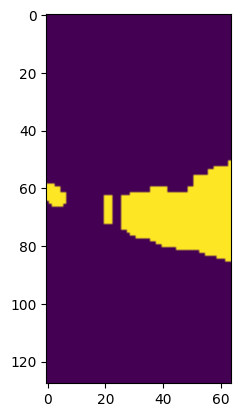

In [126]:
plt.imshow(target[0,0,80,:,:])

In [99]:
np.where(target[0,0,...] > 0)[0]


array([45, 45, 45, ..., 82, 82, 82])

In [87]:
bbox = CAL_WSISDataset.get_bbox_and_collate(target)
print(bbox)

tensor([[[45, 42,  0],
         [82, 85, 63]]])


In [111]:
slice_ = 80
line_ = 7

In [112]:
b = 0
1 - (pred[b,0,slice_,:,line_]*target[b,0,slice_,:,line_]).sum()

metatensor(1.)

In [113]:
pred[b,0,slice_,:,line_]*target[b,0,slice_,:,line_]

metatensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [122]:
target[b,0,slice_,:,:].max()

metatensor(1.)

In [77]:
Log_barrier_size_constraint_criterion(t=1e+10, mu=1.1).barrier(1 - (pred[b,0,:,line_,slice_]*target[b,0,:,line_,slice_]).sum())

metatensor(-3.4657e-10, dtype=torch.float64)

In [54]:
pred = 1-lab
target = lab

In [36]:
loss = BCELoss(reduction='none')(pred, target)
loss

metatensor([[[[[100., 100., 100.,  ..., 100., 100., 100.],
           [100., 100., 100.,  ..., 100., 100., 100.],
           [100., 100., 100.,  ..., 100., 100., 100.],
           ...,
           [100., 100., 100.,  ..., 100., 100., 100.],
           [100., 100., 100.,  ..., 100., 100., 100.],
           [100., 100., 100.,  ..., 100., 100., 100.]],

          [[100., 100., 100.,  ..., 100., 100., 100.],
           [100., 100., 100.,  ..., 100., 100., 100.],
           [100., 100., 100.,  ..., 100., 100., 100.],
           ...,
           [100., 100., 100.,  ..., 100., 100., 100.],
           [100., 100., 100.,  ..., 100., 100., 100.],
           [100., 100., 100.,  ..., 100., 100., 100.]],

          [[100., 100., 100.,  ..., 100., 100., 100.],
           [100., 100., 100.,  ..., 100., 100., 100.],
           [100., 100., 100.,  ..., 100., 100., 100.],
           ...,
           [100., 100., 100.,  ..., 100., 100., 100.],
           [100., 100., 100.,  ..., 100., 100., 100.],
         

In [ ]:
loss = loss*(1-target)
loss


In [ ]:
loss = loss/(1-target).sum(axis=(2,3,4))[...,None,None,None]
return loss.sum(axis=(1,2,3,4))